In [87]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [88]:
class BinActive(torch.autograd.Function):
    """
    This class implements a binarization activation function. 
    It binarizes the input activations using the sign function and allows gradients to pass during backpropagation.
    
    To use this class, simply call it as a function:
        binarized_activation = BinActive()(input_tensor)
    """
    
    @staticmethod
    def forward(ctx, input_tensor):
        """
        Forward pass to binarize the input.
        
        Args:
            ctx: Context object to save tensors for backward pass.
            input_tensor: Input tensor to be binarized.
        
        Returns:
            Binarized tensor.
        """
        
        # Save the input tensor for backward pass
        ctx.save_for_backward(input_tensor)
        
        # Perform binarization
        binarized_output = input_tensor.sign()
        
        return binarized_output

    @staticmethod
    def backward(ctx, grad_output):
        """
        Backward pass to allow gradients to pass through.
        
        Args:
            ctx: Context object containing saved tensors.
            grad_output: Gradient tensor from the next layer.
        
        Returns:
            Gradient tensor to pass to the previous layer.
        """
        
        # Retrieve the saved input tensor
        input_tensor, = ctx.saved_tensors
        
        # Create a gradient tensor that allows gradients to pass 
        # only where the input tensor values are between -1 and 1
        grad_input = grad_output.clone()
        grad_input = grad_input * (input_tensor <= 1).float() * (input_tensor >= -1).float()
        
        return grad_input

class BinConv2d(nn.Module):
    """
    Implements a binary convolutional layer.
    
    This class can act as a drop-in replacement for a standard nn.Conv2d layer.
    The layer includes batch normalization and an activation function.
    
    Args:
        input_channels (int): Number of input channels.
        output_channels (int): Number of output channels.
        kernel_size (int): Size of the convolutional kernel.
        stride (int): Stride of the convolution.
        padding (int): Padding added to the input.
        groups (int): Number of blocked connections from input to output channels.
        dropout (float): Dropout rate.
        Linear (bool): Whether to use linear activation. Default is False.
        is_ac (bool): Whether to apply activation function. Default is True.
    """
    
    def __init__(self, input_channels, output_channels, kernel_size, stride=1, padding=0, groups=1, dropout=0, Linear=False, is_ac=True):
        super(BinConv2d, self).__init__()
        
        # Initialize layer parameters
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.groups = groups
        self.dropout_rate = dropout
        self.is_linear = Linear
        self.is_ac = is_ac

        # Batch Normalization
        if not self.is_linear:
            self.bn = nn.BatchNorm2d(input_channels, eps=1e-4, momentum=0.1, affine=True)
            self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=groups)
        else:
            self.bn = nn.BatchNorm1d(input_channels, eps=1e-4, momentum=0.1, affine=True)
            self.linear = nn.Linear(input_channels, output_channels)

        # Activation Function
        self.relu = nn.ReLU(inplace=True)

        # Dropout Layer
        if self.dropout_rate != 0:
            self.dropout = nn.Dropout(self.dropout_rate)
        else:
            self.dropout = None

    def forward(self, x):
        """
        Forward pass through the layer.
        
        Args:
            x (Tensor): Input tensor.
        
        Returns:
            Tensor: Output of the layer.
        """
        
        # Apply Batch Norm
        x = self.bn(x)
        
        # Binarize the output
        x = BinActive.apply(x)

        # Apply Dropout if specified
        if self.dropout is not None:
            x = self.dropout(x)

        # Apply Convolution or Linear layer
        if not self.is_linear:
            x = self.conv(x)
        else:
            x = self.linear(x)
        
        # Apply Activation if specified
        if self.is_ac:
            x = self.relu(x)

        return x

class RealConv2d(nn.Module):
    """
    Implements a real-valued convolutional layer.
    
    This class can act as a drop-in replacement for a standard nn.Conv2d layer.
    The layer includes batch normalization and an activation function.
    
    Args:
        input_channels (int): Number of input channels.
        output_channels (int): Number of output channels.
        kernel_size (int): Size of the convolutional kernel.
        stride (int): Stride of the convolution.
        padding (int): Padding added to the input.
        groups (int): Number of blocked connections from input to output channels.
        dropout (float): Dropout rate.
        Linear (bool): Whether to use linear activation. Default is False.
    """
    
    def __init__(self, input_channels, output_channels, kernel_size, stride=1, padding=0, groups=1, dropout=0, Linear=False):
        super(RealConv2d, self).__init__()
        
        # Initialize layer parameters
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.groups = groups
        self.dropout_rate = dropout
        self.is_linear = Linear

        # Batch Normalization
        if not self.is_linear:
            self.bn = nn.BatchNorm2d(input_channels, eps=1e-4, momentum=0.1, affine=True)
            self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=groups)
        else:
            self.bn = nn.BatchNorm1d(input_channels, eps=1e-4, momentum=0.1, affine=True)
            self.linear = nn.Linear(input_channels, output_channels)
        
        # Activation Function
        self.relu = nn.ReLU(inplace=True)
        
        # Dropout Layer
        if self.dropout_rate != 0:
            self.dropout = nn.Dropout(self.dropout_rate)
        else:
            self.dropout = None

    def forward(self, x):
        """
        Forward pass through the layer.
        
        Args:
            x (Tensor): Input tensor.
        
        Returns:
            Tensor: Output of the layer.
        """
        
        # Apply Batch Norm
        x = self.bn(x)
        
        # Apply Dropout if specified
        if self.dropout is not None:
            x = self.dropout(x)
        
        # Apply Convolution or Linear layer
        if not self.is_linear:
            x = self.conv(x)
        else:
            x = self.linear(x)
        
        # Apply Activation
        x = self.relu(x)

        return x

def binary_conv3x3(in_channels, out_channels, stride=1, is_activation=True):
    """
    Factory function for creating a 3x3 binary convolutional layer with padding.
    
    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        stride (int): Stride of the convolution. Default is 1.
        is_activation (bool): Whether or not to include an activation function. Default is True.
        
    Returns:
        BinConv2d: 3x3 binary convolutional layer.
    """
    return BinConv2d(in_channels, out_channels, kernel_size=3, stride=stride,
                     padding=1, is_ac=is_activation)

def standard_conv3x3(in_channels, out_channels, stride=1):
    """
    Factory function for creating a standard 3x3 convolutional layer with padding.
    
    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        stride (int): Stride of the convolution. Default is 1.
        
    Returns:
        nn.Conv2d: 3x3 standard convolutional layer.
    """
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride,
                     padding=1)

def initialize_model(model):
    """
    Initialize model weights for BinConv2d and nn.BatchNorm2d layers.
    
    Args:
        model (nn.Module): The model to initialize.
    """
    for module in model.modules():
        if isinstance(module, BinConv2d):
            n = module.kernel_size[0] * module.kernel_size[1] * module.out_channels
            module.weight.data.normal_(0, math.sqrt(2. / n))
        elif isinstance(module, nn.BatchNorm2d):
            module.weight.data.fill_(1)
            module.bias.data.zero_()

class BasicBlock(nn.Module):
    """
    BasicBlock Class for ResNet.
    
    Attributes:
        expansion (int): The expansion factor for the output. Default is 1.
    """
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        """
        Initialize a BasicBlock.
        
        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            stride (int): Stride of the convolutional layer. Default is 1.
            downsample (nn.Module, optional): The downsample layer if needed.
        """
        super(BasicBlock, self).__init__()

        # First binary convolutional layer
        self.conv1 = binary_conv3x3(in_channels, out_channels, stride=stride, is_activation=True)
        
        # Second binary convolutional layer
        self.conv2 = binary_conv3x3(out_channels, out_channels, is_activation=False)
        
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        """
        Forward pass for BasicBlock.
        
        Args:
            x (Tensor): Input tensor.
        
        Returns:
            Tensor: Output tensor.
        """
        residual = x.clone()

        out = self.conv1(x)
        out = self.conv2(out)

        if self.downsample is not None:
            residual = self.downsample(residual)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    """
    Bottleneck Class for ResNet.
    
    Attributes:
        expansion (int): The expansion factor for the output. Default is 4.
    """
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        """
        Initialize a Bottleneck block.
        
        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            stride (int): Stride of the convolutional layer. Default is 1.
            downsample (nn.Module, optional): The downsample layer if needed.
        """
        super(Bottleneck, self).__init__()

        # First binary convolutional layer
        self.conv1 = BinConv2d(in_channels, out_channels, kernel_size=1, is_ac=True)
        
        # Second binary convolutional layer
        self.conv2 = BinConv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, is_ac=True)
        
        # Third binary convolutional layer
        self.conv3 = BinConv2d(out_channels, out_channels * self.expansion, kernel_size=1, is_ac=False)
        
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        """
        Forward pass for Bottleneck.
        
        Args:
            x (Tensor): Input tensor.
        
        Returns:
            Tensor: Output tensor.
        """
        residual = x

        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    """Base class for ResNet models."""
    
    def __init__(self):
        super(ResNet, self).__init__()

    def _make_layer(self, block, planes, blocks, stride=1):
        """Constructs a layer block for ResNet.
        
        Args:
            block: The class for either BasicBlock or Bottleneck.
            planes: The number of filters in the block.
            blocks: The number of blocks in the layer.
            stride: The stride of the first block.
            
        Returns:
            nn.Sequential: A sequence of blocks.
        """
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = BinConv2d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, is_ac=False)
        
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))
            
        return nn.Sequential(*layers)

    def forward(self, x):
        """Forward pass for ResNet."""
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.bn1(x)
        x = self.relu1(x)  # Changed from tanh1 to relu1 for clarity
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.bn2(x)
        x = self.relu2(x)  # Changed from tanh2 to relu2 for clarity
        x = self.fc(x)
        
        return x


class ResNet_imagenet(ResNet):
    """ResNet class for the imagenet dataset."""
    
    def __init__(self, num_classes=1000, block=Bottleneck, layers=[3, 4, 23, 3]):
        super(ResNet_imagenet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.bn2 = nn.BatchNorm1d(512 * block.expansion)
        self.relu2 = nn.ReLU(inplace=True)
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        # Removed regime as it should be part of the training script, not the model


class ResNet_cifar10(ResNet):
    """ResNet class for the CIFAR-10 dataset."""
    
    def __init__(self, num_classes=10, block=BasicBlock, depth=18):
        super(ResNet_cifar10, self).__init__()
        self.inplanes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool = nn.Identity()  # No maxpooling for CIFAR-10
        n = int((depth - 2) / 6)
        self.layer1 = self._make_layer(block, 16, n)
        self.layer2 = self._make_layer(block, 32, n, stride=2)
        self.layer3 = self._make_layer(block, 64, n, stride=2)
        self.layer4 = nn.Identity()  # No layer4 for CIFAR-10
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.bn2 = nn.BatchNorm1d(64 * block.expansion)
        self.relu2 = nn.ReLU(inplace=True)
        self.fc = nn.Linear(64 * block.expansion, num_classes)
        # Removed regime as it should be part of the training script, not the model


def resnet_factory(model_name, pretrained=None, **kwargs):
    """Factory function for creating a ResNet model.
    
    Args:
        model_name (str): Name of the model to create.
        pretrained (str, optional): Path to the pretrained model.
        
    Returns:
        nn.Module: The ResNet model.
    """
    assert model_name in ['ResNet_imagenet', 'ResNet_cifar10'], 'No such model!'
    
    if model_name == 'ResNet_imagenet':
        model = ResNet_imagenet(**kwargs)
    elif model_name == 'ResNet_cifar10':
        model = ResNet_cifar10(**kwargs)

    if pretrained is not None:
        pretrained_model = torch.load(pretrained)
        model.load_state_dict(pretrained_model['state_dict'])

    return model

In [89]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [90]:
# Load the saved ensemble
ensemble_data = torch.load('../benn-boosting/final_ensemble.pth.tar')
ensemble_models = [ResNet_cifar10().to(device) for _ in ensemble_data['models']]  # replace with actual model class
ensemble_weights = ensemble_data['weights']

# Load each state dictionary into a new model instance
for model, state_dict in zip(ensemble_models, ensemble_data['models']):
    model.load_state_dict(state_dict)
    model.eval()

Files already downloaded and verified
Ensemble Metrics:
Accuracy: 0.7268
Precision: 0.7332
Recall: 0.7268
F1 Score: 0.7279

Confusion Matrix:
Class 0:   824     10     42     23     21      6      9     11     36     18
Class 1:    32    840      9      8      2     15     19      2     29     44
Class 2:    80      1    665     44     68     36     73     19      6      8
Class 3:    29      3     94    548     58    146     82     26      3     11
Class 4:    26      2     77     49    697     37     75     36      1      0
Class 5:     9      0    100    160     63    588     32     35      2     11
Class 6:     9      0     52     61     25     26    815      7      3      2
Class 7:    16      5     50     43     69     66     11    727      3     10
Class 8:   131     16     16     21      7      8      9      7    764     21
Class 9:    54     74      6     13      4      9      5     17     18    800


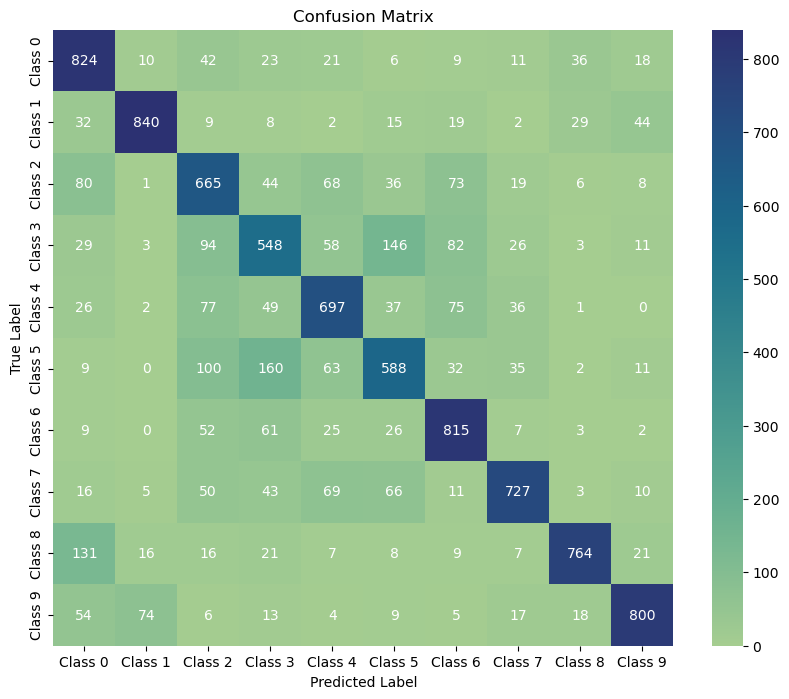

In [91]:
# Define the evaluation function for ensemble
def evaluate_ensemble(dataloader, models, weights, device):
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            ensemble_output = torch.zeros([labels.shape[0], 10], device=device)  # Adjust the size for your number of classes
            for model, weight in zip(models, weights):
                outputs = model(inputs)
                ensemble_output += weight * outputs
            _, predicted = torch.max(ensemble_output, 1)
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')  # Use 'weighted' for multi-class
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    cm = confusion_matrix(y_true, y_pred)

    return accuracy, precision, recall, f1, cm

# Data preparation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

testset = CIFAR10(root='../benn-boosting/data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Evaluate the ensemble
metrics = evaluate_ensemble(testloader, ensemble_models, ensemble_weights, device)

print("Ensemble Metrics:")
print(f"Accuracy: {metrics[0]:.4f}")  # Formatting to four decimal places
print(f"Precision: {metrics[1]:.4f}")
print(f"Recall: {metrics[2]:.4f}")
print(f"F1 Score: {metrics[3]:.4f}")

# For the confusion matrix
print("\nConfusion Matrix:")
confusion_matrix = metrics[4]
class_labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 
                'Class 5', 'Class 6', 'Class 7', 'Class 8', 'Class 9']  # Replace with your actual class labels
for i, row in enumerate(confusion_matrix):
    joined_row = "  ".join(f"{num:5d}" for num in row)
    print(f"{class_labels[i]}: {joined_row}")


confusion_matrix = np.array([[824,  10,  42,  23,  21,   6,   9,  11,  36,  18],
                             [ 32, 840,   9,   8,   2,  15,  19,   2,  29,  44],
                             [ 80,   1, 665,  44,  68,  36,  73,  19,   6,   8],
                             [ 29,   3,  94, 548,  58, 146,  82,  26,   3,  11],
                             [ 26,   2,  77,  49, 697,  37,  75,  36,   1,   0],
                             [  9,   0, 100, 160,  63, 588,  32,  35,   2,  11],
                             [  9,   0,  52,  61,  25,  26, 815,   7,   3,   2],
                             [ 16,   5,  50,  43,  69,  66,  11, 727,   3,  10],
                             [131,  16,  16,  21,   7,   8,   9,   7, 764,  21],
                             [ 54,  74,   6,  13,   4,   9,   5,  17,  18, 800]])

plt.figure(figsize=(10, 8))
ax = sns.heatmap(confusion_matrix, cmap='crest', xticklabels=class_labels, yticklabels=class_labels)

# Loop over data dimensions and create text annotations.
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        ax.text(j + 0.5, i + 0.5, format(confusion_matrix[i, j], 'd'),
                ha="center", va="center", color="w")

plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()